<a href="https://colab.research.google.com/github/ali77sina/mult_ob_opt/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
#installing skopt library
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
#importing relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skopt import gp_minimize
from sklearn.utils import shuffle
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.metrics import auc
from skopt import gp_minimize
from skopt.space.space import Integer
from tensorflow.keras.models import Model

In [78]:
snip_len = 1 #snippet length in secs
fs = 256 #sampling freq
win_size = 30 #window size of input
f_max = 100 #maximum frequency to be sampled
t = np.linspace(0, snip_len, fs*snip_len) #vector of time for snippet
f_low = 1 #lower boundry for detection of snippet
f_high = 50 #higher boundry for detection of snippet

In [79]:
x_train = []  #list to create training data
y_train = []  #labels for training data
for _ in range(100):  #loop to create the training dataset
  f = np.random.random()*f_max  #frequency of the current snippet
  if f>f_low and f<f_high:  #if statement for the label 
    y = 1 #positive if the freq is within range 
  else: #0 if not within range
    y = 0
  x = np.sin(2*np.pi*f*t) #snippet of sine wave
  x += np.random.normal(0,0.1,len(x)) #adding gaussian noise
  for i in range(len(x) - win_size):  #loop to create training data
    x_train.append(x[i:i+win_size])
    y_train.append(y)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train, y_train = shuffle(x_train, y_train)
print(x_train.shape)
print(y_train.shape)

(22600, 30)
(22600,)


In [80]:
x_test = []  #list to create test data
y_test = []  #labels for test data
for _ in range(50):  #loop to create the training dataset
  f = np.random.random()*f_max  #frequency of the current snippet
  if f>f_low and f<f_high:  #if statement for the label 
    y = 1 #positive if the freq is within range 
  else: #0 if not within range
    y = 0
  x = np.sin(2*np.pi*f*t) #snippet of sine wave
  x += np.random.normal(0,0.1,len(x)) #adding gaussian noise
  for i in range(len(x) - win_size):  #loop to create test data
    x_test.append(x[i:i+win_size])
    y_test.append(y)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test, y_test = shuffle(x_test, y_test)
print(x_test.shape)
print(y_test.shape)

(11300, 30)
(11300,)


few functions to use during optimization

In [81]:
#function to return fpr and tpr for ROC
def ROC(y_true, y_pred, threshold_range):
    fpr = []  #vector to save false positive rate
    tpr = []  #vector to save true positive rate
    for thr in threshold_range: #loop going thorugh each thresholds
        tp = 0  #true positive
        fp = 0  #false positive
        tn = 0  #true negative
        fn = 0  #false negative
        new_y = np.zeros(len(y_pred)) #vector to store binary prediction based on current threshold
        for num,i in enumerate(y_pred):
            if i > thr:
                new_y[num] = 1
        for i,j in zip(y_true, new_y):  #loop to calculate metrics
            if i == j and i == 1:
                tp += 1
            if i == j and i == 0:
                tn += 1
            if i == 1 and j == 0:
                fn += 1
            if i == 0 and j == 1:
                fp += 1
        tpr.append(tp/(fn+tp))
        fpr.append(fp/(tn+fp))
    plt.plot(fpr, tpr)
    return fpr, tpr

#function to create model 
#2 variables to be optimized are nodes in 2 hidden layers, d1 and d2
def creat_model(d1,d2):
  inp = Input((win_size))
  x = Dense(d1, activation = 'relu')(inp)
  Dropout(0.2)(x)
  x = Dense(d2, activation = 'relu')(x)
  Dropout(0.2)(x)
  out = Dense(1, activation = 'sigmoid')(x)
  model = Model(inputs = inp, outputs = out)
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return model

#function to return AUC value
def return_auc(params):
  model = creat_model(params[0],params[1])
  model.fit(x_train, y_train, batch_size = 128, epochs = 3)  #training model 
  y_pred = model.predict(x_test)
  fpr, tpr = ROC(y_test, y_pred, np.linspace(0,1,20))
  auc_val = auc(fpr, tpr)
  print('AUC is {}'.format(auc_val))
  return -auc_val #returning negative value since the GP is minizmizing it


Epoch 1/3
177/177 [==============================] - 1s 3ms/step - loss: 0.6061 - accuracy: 0.6773
Epoch 2/3
177/177 [==============================] - 0s 2ms/step - loss: 0.2885 - accuracy: 0.9298
Epoch 3/3
354/354 [==============================] - 1s 2ms/step
AUC is 0.9996624808043937
Epoch 1/3
177/177 [==============================] - 2s 5ms/step - loss: 0.3255 - accuracy: 0.8981
Epoch 2/3
177/177 [==============================] - 1s 4ms/step - loss: 0.0366 - accuracy: 0.9909
Epoch 3/3
354/354 [==============================] - 2s 5ms/step
AUC is 1.0
Epoch 1/3
177/177 [==============================] - 2s 5ms/step - loss: 0.4445 - accuracy: 0.8092
Epoch 2/3
177/177 [==============================] - 1s 5ms/step - loss: 0.0846 - accuracy: 0.9845
Epoch 3/3
354/354 [==============================] - 2s 4ms/step
AUC is 1.0
Epoch 1/3
177/177 [==============================] - 1s 2ms/step - loss: 0.4365 - accuracy: 0.8043
Epoch 2/3
177/177 [==============================] - 0s 2ms/step

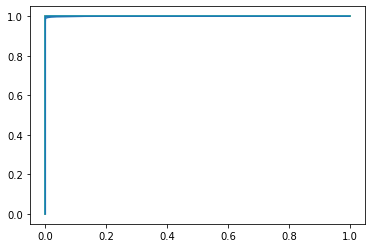

In [82]:
#running optimization
default_parameters = [8, 8] #initial params
d1 = Integer(low=4, high=32, name='d1') #nodes in first layer
d2 = Integer(low=4, high=32, name='d2') #nodes in second layer
dimensions = [d1, d2]
search_result = gp_minimize(func=return_auc,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=11,
                            x0=default_parameters)


In [83]:
print(search_result.x) #corresponding values
print(search_result.fun) #corresponding AUC

[30, 30]
-1.0


Epoch 1/3
177/177 [==============================] - 1s 3ms/step - loss: 0.5939 - accuracy: 0.7066
Epoch 2/3
177/177 [==============================] - 0s 2ms/step - loss: 0.2696 - accuracy: 0.9391
Epoch 3/3
354/354 [==============================] - 1s 3ms/step
AUC is 0.9999989911153837
Epoch 1/3
177/177 [==============================] - 2s 5ms/step - loss: 0.5527 - accuracy: 0.7489
Epoch 2/3
177/177 [==============================] - 1s 5ms/step - loss: 0.1730 - accuracy: 0.9742
Epoch 3/3
354/354 [==============================] - 1s 3ms/step
AUC is 0.9999998581256009
Epoch 1/3
177/177 [==============================] - 3s 7ms/step - loss: 0.5280 - accuracy: 0.7602
Epoch 2/3
177/177 [==============================] - 1s 7ms/step - loss: 0.2442 - accuracy: 0.9499
Epoch 3/3
354/354 [==============================] - 1s 2ms/step
AUC is 0.9999991802812493
Epoch 1/3
177/177 [==============================] - 1s 2ms/step - loss: 0.5435 - accuracy: 0.7567
Epoch 2/3
177/177 [===============

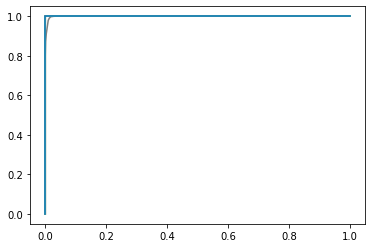

In [84]:
auc_vec = []  #vector to store AUC values 

#func to calculate total number of params
def total_number(model):
    trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    totalParams = trainableParams + nonTrainableParams
    return totalParams

#function to return AUC value
def return_auc_HW(params):
  model = creat_model(params[0],params[1])
  model.fit(x_train, y_train, batch_size = 128, epochs = 3)  #training model 
  y_pred = model.predict(x_test)
  fpr, tpr = ROC(y_test, y_pred, np.linspace(0,1,20))
  auc_val = auc(fpr, tpr)
  print('AUC is {}'.format(auc_val))
  total_n = total_number(model)
  lmbda = 0.01
  global auc_vec
  auc_vec.append(auc_val)
  return -auc_val + lmbda*total_n #returning negative value since the GP is minizmizing it

#running optimization
default_parameters = [8, 8] #initial params
d1 = Integer(low=4, high=32, name='d1') #nodes in first layer
d2 = Integer(low=4, high=32, name='d2') #nodes in second layer
dimensions = [d1, d2]
search_result_hw = gp_minimize(func=return_auc_HW,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=11,
                            x0=default_parameters)

In [85]:
print(search_result_hw.x) #corresponding values
print(search_result_hw.fun) #corresponding AUC + params related loss

for num,i in enumerate(search_result_hw.x_iters):
  if i == search_result_hw.x:
    auc_val = auc_vec[num]

[8, 8]
2.2900010088846163


In [86]:
model_norm = creat_model(search_result.x[0], search_result.x[1])  #params optimized only for performance
model_HW = creat_model(search_result_hw.x[0], search_result_hw.x[1])  #params optimized with num of params
param_norm = total_number(model_norm)
param_HW = total_number(model_HW)
print('new model is x{} times smaller'.format(param_norm/param_HW))
print('HW model AUC:{}, Performance model AUC: {}'.format(auc_val, -search_result.fun))
print('difference in AUC values: {}'.format(-search_result.fun - auc_val))

new model is x5.7477203647416415 times smaller
HW model AUC:0.9999989911153837, Performance model AUC: 1.0
difference in AUC values: 1.0088846162936704e-06
